### load documents with ID

In [1]:
import json as json 
with open("../03-vector-search/documents_id.json","rt") as file_in:
     documents = json.load(file_in)

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'fa0d2d83'}

### Load ground truth data

In [3]:
import pandas as pd

In [4]:
ground_truth = (pd.read_csv("../03-vector-search/ground-truth-data.csv")).to_dict(orient="records")

In [10]:
ground_truth[10]

{'question': 'Is it possible to enroll in the course after it begins?',
 'course': 'data-engineering-zoomcamp',
 'document': 'bc44dd09'}

In [6]:
doc_idx = {d['id'] : d for d in documents}


In [9]:
doc_idx['bc44dd09']['text']

"Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute."

### Index data

In [11]:
from sentence_transformers import SentenceTransformer
model_name = "multi-qa-MiniLM-L6-cos-v1"
model = SentenceTransformer(model_name)

In [12]:
from elasticsearch import Elasticsearch

e_client = Elasticsearch('http://localhost:9200')

e_client.info()

ObjectApiResponse({'name': '5be13035b0f9', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'sGmOkZVAT3GhdEu0nrOzMg', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [13]:
index_name = "questions-vector"

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {"type": "dense_vector","dims": 384,"index": True,"similarity":"cosine"}



        }
    }
}

e_client.indices.delete(index=index_name,ignore_unavailable=True)
e_client.indices.create(index=index_name,body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'questions-vector'})

In [14]:
from tqdm.auto import tqdm


for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']

    doc['question_text_vector'] = model.encode(question + ' ' + text)

    e_client.index(index=index_name,document=doc)


100%|██████████| 948/948 [01:12<00:00, 13.07it/s]


### Retrieval

In [20]:
def elastic_search_knn(field,vector,course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn" : knn,
        "_source": ["text","section","question","course","id"]
    }

    es_results = e_client.search(
        index=index_name,
        body=search_query
    )


    result_docs = []

    for hit in es_results['hits']['hits']:
        result_docs.append(hit["_source"])

    return result_docs



def question_text_vector_knn(q):
    question = q['question']
    course = q['course']


    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector',v_q,course)

In [21]:
question_text_vector_knn(dict(
    question="Are sessions recorded if i miss one?",
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '71f12856'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': 'b6e2390e'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

### Build Prompt 

In [28]:
def build_prompt(query,search_results):
    prompt_template = """
                    You're a course teaching assistant. Answer the question based on the context from the FAQ database.
                    Use only the facts from the CONTEXT when answering the Question.

                    QUESTION: {question}

                    CONTEXT: {context}

                    """.strip()
    
    context = ""

    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"

    prompt = prompt_template.format(question=query,context=context).strip()

    #print(prompt)

    return(prompt)




In [23]:
from openai import OpenAI

o_client = OpenAI(api_key="")

In [48]:
def llm(prompt,model):
    response = o_client.chat.completions.create(
        model=model,
        messages=[{"role":"user","content": prompt}]
    )

    return response.choices[0].message.content

In [49]:
def rag(query: dict,model) -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'],search_results)
    answer = llm(prompt,model)
    return answer


In [26]:
ground_truth[10]

{'question': 'Is it possible to enroll in the course after it begins?',
 'course': 'data-engineering-zoomcamp',
 'document': 'bc44dd09'}

In [32]:
answer_llm = rag(ground_truth[10])
answer_orig = doc_idx['bc44dd09']['text']
v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

### Cosine similarity metric

In [33]:
v_llm.dot(v_orig)

0.7637447

In [37]:
answers = {}

In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    answer_llm = rag(rec,"gpt-4o")
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']


    answers[i] = {
         'answer_llm' : answer_llm,
         'answer_orig': answer_orig,
         'documents': doc_id,
         'question': rec['question'],
         'course': rec['course']

    }

In [40]:
len(answers)

1045

In [41]:
results_gpt4o = [None] * 1045

In [42]:
for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [43]:
results_gpt4o

[{'answer_llm': 'The course will commence on 15th January 2024 at 17:00.',
  'answer_orig': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'documents': '23cb47db',
  'question': 'On what date and time does the course commence?',
  'course': 'data-engineering-zoomcamp',
  'document': '23cb47db'},
 {'answer_llm': "To subscribe to the course's public Google Calendar, please note that it works from Desktop only. You should register before the course starts using the provided link.",
  'answer_orig': "The purpose of this document is to capture frequently asked technical quest

In [44]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [47]:
df_gpt4o.to_csv("results_gpt4o.csv",index=False)

### Evaluating GPT 3.5

In [53]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=10)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [54]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [52]:
process_record(ground_truth[10])

{'answer_llm': "Yes, it is possible to enroll in the course after it begins. Even if you don't register, you're still eligible to submit the homeworks. Just keep in mind that there will be deadlines for turning in the final projects, so it's advised not to leave everything for the last minute.",
 'answer_orig': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.",
 'document': 'bc44dd09',
 'question': 'Is it possible to enroll in the course after it begins?',
 'course': 'data-engineering-zoomcamp'}

In [ ]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

In [57]:
results_gpt4o[0]

{'answer_llm': 'The course will commence on 15th January 2024 at 17:00.',
 'answer_orig': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'documents': '23cb47db',
 'question': 'On what date and time does the course commence?',
 'course': 'data-engineering-zoomcamp',
 'document': '23cb47db'}

### Cosine similarity

In [59]:
def compute_similarity(record):
    answer_llm = record['answer_llm']
    answer_orig = record['answer_orig']

    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)

    return v_llm.dot(v_orig)


In [60]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 1045/1045 [01:23<00:00, 12.51it/s]


In [61]:
df_gpt4o['consine'] = similarity

In [62]:
df_gpt4o['consine'].describe()

count    1045.000000
mean        0.699797
std         0.187458
min        -0.047405
25%         0.601094
50%         0.733209
75%         0.837057
max         1.000000
Name: consine, dtype: float64

In [63]:
import seaborn as sns

/var/folders/7y/s3kmp4m92dx3v5vx5mf7csgh0000gn/T/ipykernel_65433/2938190229.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['consine'])


<Axes: xlabel='consine', ylabel='Density'>

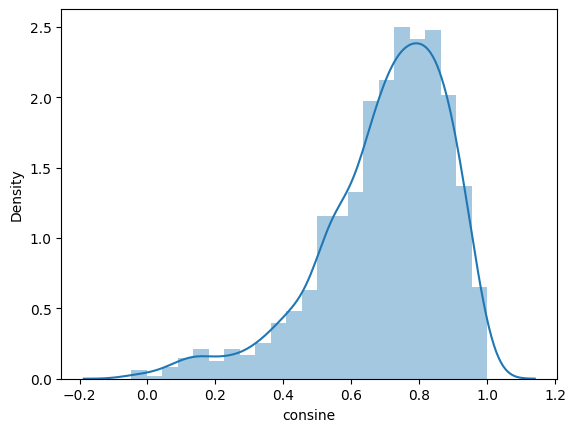

In [67]:
sns.distplot(df_gpt4o['consine'])

## LLM AS A JUDGE

In [70]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [72]:
df_sample = df_gpt4o.sample(n=150, random_state=1)

samples = df_sample.to_dict(orient='records')

In [74]:
record = samples[0]

prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: This happened when I just booted up my PC, continuing from the progress I was doing from yesterday.
After cd-ing into your directory, and running docker compose up , the web interface for the Mage shows, but the files that I had yesterday was gone.
If your files are gone, go ahead and close the web interface, and properly shutting down the mage docker compose by doing Ctrl + C once. Try running it again. This worked for me more than once (yes the issue persisted with my PC twice)
Also, you should check if you’re in the correct repository before doing docker compose up . This was discussed in the Sl

In [75]:
import json

answer = llm(prompt,model='gpt-4o-mini')

json.loads(answer)

{'Relevance': 'PARTLY_RELEVANT',
 'Explanation': "The generated answer partially addresses the user's need for information about discussions related to the issue within the course community. While it does not directly quote or reference the original answer's suggestions about using the Slack #course-data-engineering channel, it provides alternative platforms (Telegram and DataTalks.Club's Slack) where discussions may occur. However, the relevance is diminished because it does not fully align with the specific resources mentioned in the original answer."}

In [76]:
answers = []


for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    answer = llm(prompt,model='gpt-4o-mini')
    answers.append(answer)


100%|██████████| 150/150 [04:27<00:00,  1.79s/it]


In [77]:
json_evaluations = []

for i, str_eval in enumerate(answers):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [78]:
df_evaluations = pd.DataFrame(json_evaluations)

In [79]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           130
PARTLY_RELEVANT     16
NON_RELEVANT         4
Name: count, dtype: int64

In [80]:
answers_2 = []


for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    answer = llm(prompt,model='gpt-4o-mini')
    answers_2.append(answer)

100%|██████████| 150/150 [04:03<00:00,  1.62s/it]


In [84]:
json_evaluations_2 = []

for i, str_eval in enumerate(answers_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

JSONDecodeError: Expecting ',' delimiter: line 3 column 73 (char 108)

In [ ]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)